# Grounded Segement Anything

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Prepare Environments

In [2]:
! python -m pip install -e segment_anything
! python -m pip install -e GroundingDINO
! pip install diffusers transformers accelerate scipy safetensors

ERROR: segment_anything is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
ERROR: GroundingDINO is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [ ]:
%cd /home/novellaalvina/Documents/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /home/novellaalvina/Documents/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /home/novellaalvina/Documents/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /home/novellaalvina/Documents/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything

/content/drive/MyDrive/MS/RA/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [18]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [19]:
!pip install supervision==0.7.0

In [20]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/content/drive/MyDrive/MS/RA/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/content/drive/MyDrive/MS/RA/YixuanPaper/Grounded-SAM/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


# Load Grounding DINO model

In [21]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [22]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [23]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

<ipython-input-21-87299579a18e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cache_file, map_location='cpu')


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


# Load SAM model

In [24]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-01-06 22:47:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.66, 3.167.112.53, 3.167.112.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.2’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  50.9MB/s    in 49s     

2025-01-06 22:48:13 (50.4 MB/s) - ‘sam_vit_h_4b8939.pth.2’ saved [2564550879/2564550879]



In [25]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# Load stable diffusion inpainting models

In [26]:
from diffusers import StableDiffusionInpaintPipeline

if DEVICE.type == 'cpu':
    float_type = torch.float32
else:
    float_type = torch.float16

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=float_type,
)

if DEVICE.type != 'cpu':
    pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Load demo image

In [27]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)

In [28]:
# image from demo
local_image_path = 'assets/inpaint_demo.jpg'

In [47]:
# image from Yixuan
local_image_path = "/content/drive/MyDrive/MS/RA/YixuanPaper/Grounded-SAM/rgb_0056.png"

# Run Grounding DINO for detection

In [ ]:
# args from demo
TEXT_PROMPT = "bench"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [48]:
TEXT_PROMPT = "cups"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [49]:
image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

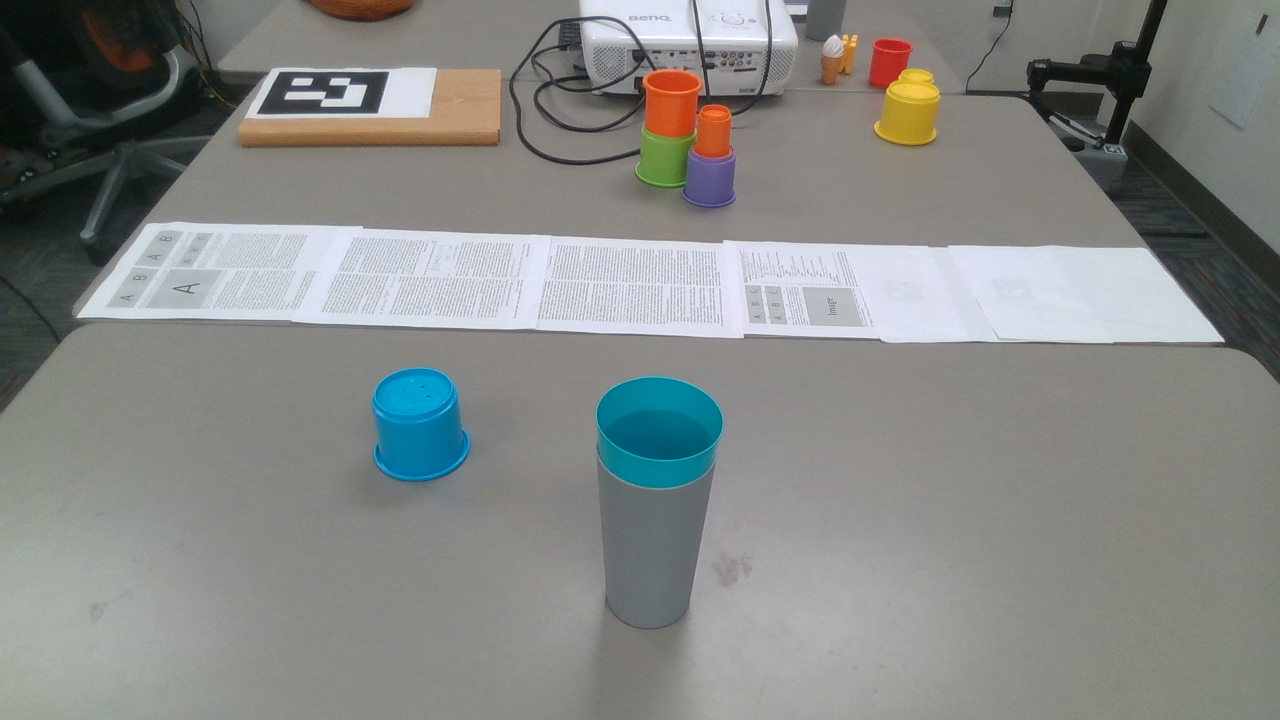

In [50]:
Image.fromarray(image_source)

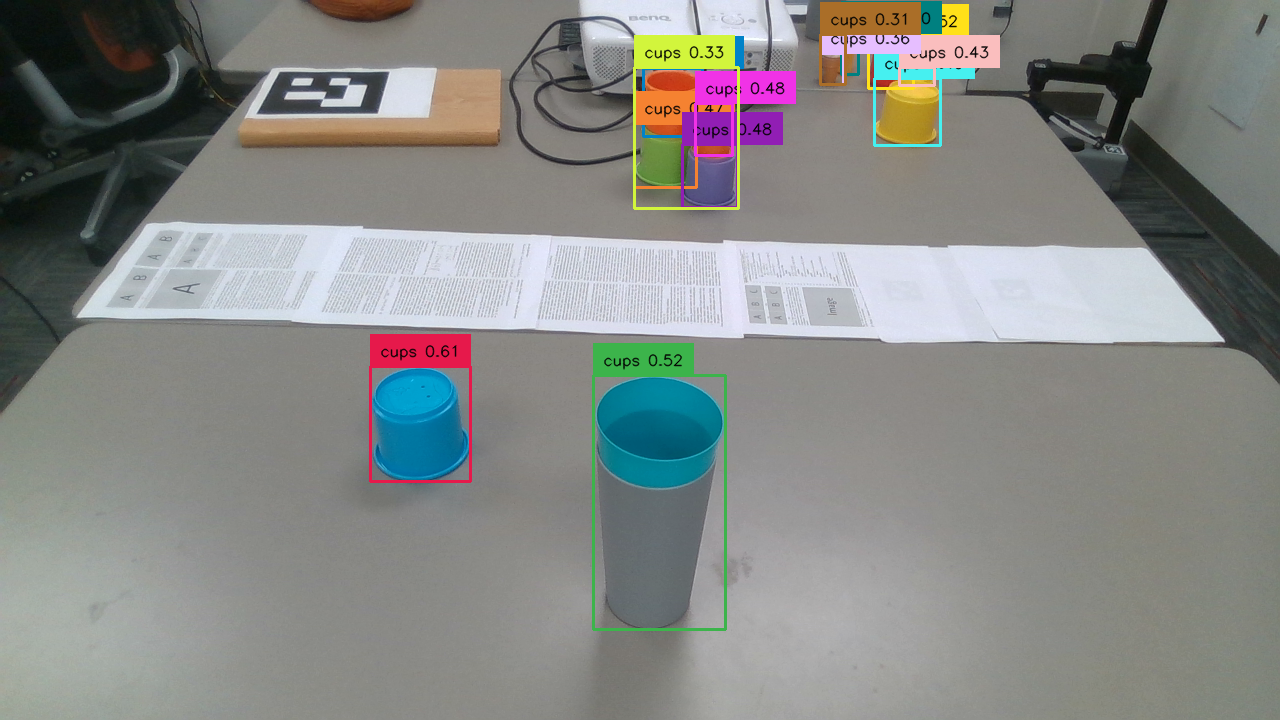

In [51]:
Image.fromarray(annotated_frame)

# Run the segmentation model

In [ ]:
# set image
sam_predictor.set_image(image_source)

In [ ]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [ ]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


In [ ]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

In [ ]:
Image.fromarray(annotated_frame_with_mask)

# Image Inpainting

In [39]:
image_mask = masks[0][0].cpu().numpy()

In [40]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

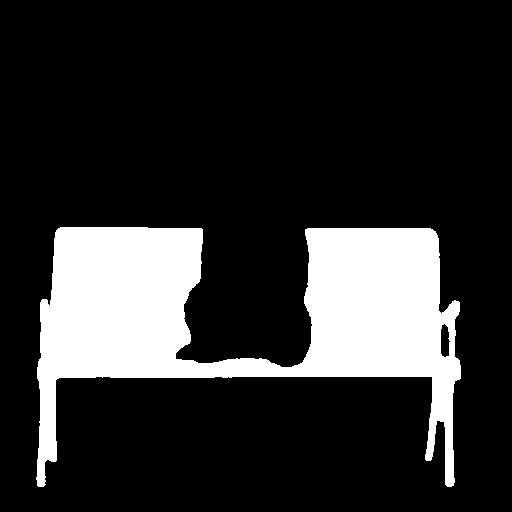

In [41]:
image_mask_pil

In [42]:
# resize for inpaint
image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))

In [43]:
prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

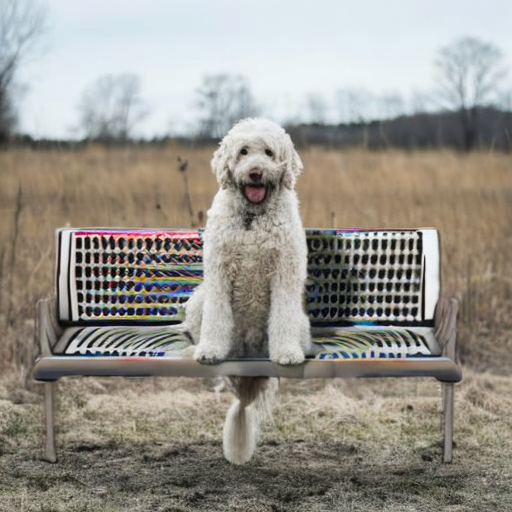

In [45]:
image_inpainting